# 第5章 RNN

## 概率和语言模型

### 概率视角下的word2vec

![](./img/5-1.png)

![](./img/5.1.png)

![](./img/5-2.png)

![](./img/5.2.png)

![](./img/5.3.png)

### 语言模型

![](./img/5.4.png)

![](./img/5.5.png)

![](./img/5.6.png)

![](./img/5.7.png)

![](./img/5-3.png)

### 将CBOW模型用作语言模型

![](./img/5.8.png)

![](./img/5-4.png)

![](./img/5-5.png)

## RNN

![](./img/bq4.png)

### 循环的神经网络

RNN

xt

ht

ht是复制的

![](./img/5-6.png)

就像血液在我们身体里的循环

为了排版方便改为由下到上

![](./img/5-7.png)

### 展开循环

![](./img/5-8.png)

这些RNN都是同一个层

RNN具有状态h

h以下面的公式被更新

![](./img/5.9.png)

tanh双曲正切

本书与其他书的画法对比

![](./img/5-9.png)

### Backpropagation Through TIme

反向传播

![](./img/5-10.png)

- 计算资源

- 内存

- 梯度消失

### Truncated BPTT

反向传播截断

![](./img/5-11.png)

假如有1000个单词的语料库（多个串联起来的句子当作一个时序数据）

长度为1000的时序数据

正向正常

反向以10个为单位

x0-x9

![](./img/5-12.png)

x10-x19

![](./img/5-13.png)

![](./img/514.png)

### Truncated BPTT 的 mini-batch

还是这个例子，假设batch-size=2

![](./img/5-15.png)

![](./img/bq1.png)

## RNN的实现

单步RNN层 class RNN

![](./img/5-16.png)

 一次处理T步的层 class TimeRNN

![](./img/5-17.png)

### RNN层的实现

公式

![](./img/5.10.png)

矩阵形状检查

![](./img/5-18.png)

In [ ]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

正向

![](./img/5-19.png)

反向

![](./img/5-20.png)

In [ ]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### TIme RNN层的实现

Time RNN 层由 T 个 RNN 层构成（T 可以设置为任意值），如图 

![](./img/5-21.png)

这里，RNN 层的隐藏状态 h 保存在成员变量中。

在进行隐藏状态的“继承”时会用到它。

![](./img/5-22.png)

另外，我们可以用 stateful 这个参数来控制是否继承隐藏状态。

下面，我们来看一下 Time RNN 层的实现。首先实现初始化方法和两个方法

In [ ]:
# common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        #  stateful 是“有状态”的意思
        # 当stateflul=True
        # 无论时序数据多长，Time RNN层的正向传播都可以不中断地进行。

        # 当 stateful 为 False 时
        # 每次调用Time RNN 层的 forward() 时，第一个 RNN 层的隐藏状态都会被初始化为零矩阵
        
        self.params = [Wx, Wh, b] # 权重、偏置
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # 在列表中保存多个 RNN 层

        self.h, self.dh = None, None 
        # h 保存调用 forward() 方法时的最后一个 RNN 层的隐藏状态
        # 在调用backward() 时，dh 保存传给前一个块的隐藏状态的梯度
        
        self.stateful = stateful # 布尔型（True/False）的 stateful

    def set_state(self, h): # 设定 Time RNN 层的隐藏状态
        self.h = h

    def reset_state(self): #重设隐藏状态
        self.h = None 

接着，我们来看一下正向传播的实现。

In [ ]:
# common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs): # 输入 xs，xs 囊括了 T 个时序数据。
        Wx, Wh, b = self.params
        N, T, D = xs.shape # 批大小是 N，输入向量的维数是 D，xs 的形状为 (N,T,D)
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f') #  首先通过 hs=np.empty((N, T, H), dtype='f') 为输出准备一个“容器”

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f') 
            # 在成员变量 stateful 为 False 的情况下，h 将总是被重置为零矩阵。
            # 在首次调用时（self.h 为 None 时），RNN 层的隐藏状态 h 由所有元素均为 0 的矩阵初始化。
        
        # 在 T 次 for 循环中，生成 RNN 层，并将其添加到成员变量 layers 中
        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h) # 计算 RNN 层各个时刻的隐藏状态
            hs[:, t, :] = self.h # 并存放在 hs的对应索引（时刻）中
            self.layers.append(layer)

        return hs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

如果调用 Time RNN 层的 forward()方法，则成员变量 h中将存放最后一个 RNN 层的隐藏状态。

在 stateful为 True的情况下，在下一次调用 forward()方法时，刚才的成员变量 h将被继续使用。

而在stateful为 False的情况下，成员变量 h将被重置为零向量。

反向传播

![](./img/5-23.png)

将从上游（输出侧的层）传来的梯度记为 dhs，将流向下游的梯度记为 dxs。

因为这里我们进行的是 Truncated BPTT，所以不需要流向这个块上一时刻的反向传播。

不过，我们将流向上一时刻的隐藏状态的梯度存放在成员变量 dh 中。

这是因为在第 7 章探讨 seq2seq时会用到它。

以上就是Time RNN层的反向传播的全貌图。

如果关注第t个RNN层，则它的反向传播如图所示

![](./img/5-24.png)

从上方传来的梯度 dht 和从将来的层传来的梯度 dhnext 会传到第 t 个RNN 层。

这里需要注意的是，RNN 层的正向传播的输出有两个分叉。

在正向传播存在分叉的情况下，在反向传播时各梯度将被求和。

因此，在反向传播时，流向 RNN 层的是求和后的梯度。

考虑到以上这些，反向传播的实现

如下所示

In [ ]:
# common/time_layers.py
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f') # 首先创建传给下游的梯度的“容器”（dxs）
        dh = 0
        grads = [0, 0, 0]
        
        # 着，按与正向传播相反的方向，调用 RNN 层的 backward() 方法
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 求得各个时刻的梯度 dx
            dxs[:, t, :] = dx # 并存放在 dxs 的对应索引处
            
            # 关于权重参数，需要求各个 RNN 层的权重梯度的和
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                # 在 Time RNN 层中有多个 RNN 层。另外，这些 RNN 层使用相同的权重。
                # 因此，Time RNN 层的（最终）权重梯度是各个 RNN层的权重梯度之和。
        
        # 用最终结果覆盖成员变量 self.grads
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

## 处理时序数据的层的实现本

基于 RNN 的语言模型称为 RNNLM（RNN Language Model，RNN 语言模型）

为了这个模型我们还要做点工作

### RNNLM的全貌图

首先，我们看一下 RNNLM 使用的网络

最简单的RNNLM 的网络，其中左图显示了 RNNLM 的层结构，右图显示了在时间轴上展开后的网络

![](./img/5-25.png)

的第 1 层是 Embedding 层，该层将单词 ID 转化为单词的分布式表示（单词向量）。

然后，这个单词向量被输入到 RNN 层。

RNN 层向下一层（上方）输出隐藏状态，同时也向下一时刻的 RNN 层（右侧）输出隐藏状态。

RNN 层向上方输出的隐藏状态经过 Affine 层，传给 Softmax 层。

说明一下整个过程

这里使用的句子还是我们熟悉的“you say goodbye and i say hello.”

![](./img/5-26.png)

根据之前输入的所有文字，预测下一个单词

### TIme层的实现

不止RNN要有TimeRNN

其他的层配套也要跟上

![](./img/5-27.png)

#### Time Embedding

在正向传播时准备 T 个 Embedding 层，由各个 Embedding 层处理各个时刻的数据。

In [ ]:
class TimeEmbedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W

    def forward(self, xs):
        N, T = xs.shape # 比如我们例子的情况 10* 5
        V, D = self.W.shape # 

        out = np.empty((N, T, D), dtype='f')
        self.layers = []

        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, D = dout.shape

        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]

        self.grads[0][...] = grad
        return None


#### Time Affine

只需准备 T 个 Affine 层分别处理各个时刻的数据即可。

![](./img/5-28.png)

In [ ]:
class Simple_TimeAffine:
    def __init__(self, W, b):
        self.W, self.b = W, b
        self.dW, self.db = None, None
        self.layers = None

    def forward(self, xs):
        N, T, D = xs.shape
        D, M = self.W.shape

        self.layers = []
        out = np.empty((N, T, M), dtype='f')
        for t in range(T):
            layer = Affine(self.W, self.b)
            out[:, t, :] = layer.forward(xs[:, t, :])
            self.layers.append(layer)

        return out

    def backward(self, dout):
        N, T, M = dout.shape
        D, M = self.W.shape

        dxs = np.empty((N, T, D), dtype='f')
        self.dW, self.db = 0, 0
        for t in range(T):
            layer = self.layers[t]
            dxs[:, t, :] = layer.backward(dout[:, t, :])

            self.dW += layer.dW
            self.db += layer.db

        return dxs

使用矩阵运算实现了高效的整体处理。

In [ ]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params

        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)

    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params

        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)

        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)

        self.grads[0][...] = dW
        self.grads[1][...] = db

        return dx

#### Time Softmaxwithloss

接下来我们看一下时序版本的 Softmax。

我们在 Softmax 中一并实现损失误差 Cross Entropy Error 层。

![](./img/5-29.png)

x0、x1 等数据表示从下方的层传来的得分（得分是正规化为概率之前的值）

t0、t1 等数据表示正确解标签。

T 个Softmax with Loss 层各自算出损失，然后将它们加在一起取平均，将得到的值作为最终的损失。

In [ ]:
class Simple_TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None

    def forward(self, xs, ts):
        N, T, V = xs.shape
        layers = []
        loss = 0

        for t in range(T):
            layer = SoftmaxWithLoss()
            loss += layer.forward(xs[:, t, :], ts[:, t])
            layers.append(layer)
        loss /= T

        self.cache = (layers, xs)
        return loss

    def backward(self, dout=1):
        layers, xs = self.cache
        N, T, V = xs.shape
        dxs = np.empty(xs.shape, dtype='f')

        dout *= 1/T
        for t in range(T):
            layer = layers[t]
            dxs[:, t, :] = layer.backward(dout)

        return dxs

顺便说一下，本书的Softmax with Loss层计算mini-batch的平均损失。

具体而言，假设 mini-batch 有 N 笔数据，通过先求 N 笔数据的损失之和，再除以 N，可以得到单笔数据的平均损失。

这里也一样，通过取时序数据的平均，可以求得单笔数据的平均损失作为最终的输出。

In [ ]:
class TimeSoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1

    def forward(self, xs, ts):
        N, T, V = xs.shape

        if ts.ndim == 3:  # 在监督标签为one-hot向量的情况下
            ts = ts.argmax(axis=2)

        mask = (ts != self.ignore_label)

        # 按批次大小和时序大小进行整理（reshape）
        xs = xs.reshape(N * T, V)
        ts = ts.reshape(N * T)
        mask = mask.reshape(N * T)

        ys = softmax(xs)
        ls = np.log(ys[np.arange(N * T), ts])
        ls *= mask  # 与ignore_label相应的数据将损失设为0
        loss = -np.sum(ls)
        loss /= mask.sum()

        self.cache = (ts, ys, mask, (N, T, V))
        return loss

    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache

        dx = ys
        dx[np.arange(N * T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]  # 与ignore_label相应的数据将梯度设为0

        dx = dx.reshape((N, T, V))

        return dx


## RNNLM的学习和评价

实现 RNNLM 所需要的层都已经准备好了，现在我们来实现 RNNLM，
并对其进行训练，然后再评价一下它的结果。

### RNNLM的实现

使用方法与功能

In [96]:
from common.optimizer import SGD
# 设定超参数
batch_size = 10 # 小批量
wordvec_size = 100 # 
hidden_size = 100 # 隐藏层
time_size = 5  # Truncated BPTT的时间跨度大小
lr = 0.1

In [97]:
batch_x =np.array([[  0,   1,   2,   3,   4],
                   [ 76,  77,  64,  78,  79],
                   [ 98,  56,  40, 128,  29],
                   [175,  98,  61,  54,  63],
                   [ 32,  82,  98,  24,  32],
                   [241, 242,  42,  61,  26],
                   [229,  27, 277, 275, 278],
                   [ 24, 141, 119, 142, 306],
                   [ 27,  27, 181,  32, 351],
                   [229, 307,  64, 220,  35]], dtype='i')

In [98]:
batch_t =np.array([[  1,   2,   3,   4,   5],
                   [ 77,  64,  78,  79,  80],
                   [ 56,  40, 128,  29, 129],
                   [ 98,  61,  54,  63, 108],
                   [ 82,  98,  24,  32,  26],
                   [242,  42,  61,  26, 243],
                   [ 27, 277, 275, 278, 276],
                   [141, 119, 142, 306,  93],
                   [ 27, 181,  32, 351, 352],
                   [307,  64, 220,  35, 389]], dtype='i')

In [99]:
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size) # 418 100 100

In [100]:
optimizer = SGD(lr)
loss = model.forward(batch_x, batch_t)
loss

6.03281494140625

In [101]:
model.backward()
optimizer.update(model.params, model.grads)

这里我们将 RNNLM 使用的网络实现为 SimpleRnnlm 类，内部结构

![](./img/5-30.png)

SimpleRnnlm 类是一个堆叠了 4 个 Time 层的神经网络。

In [ ]:
# ch05/simple_rnnlm.py

import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn 

        # 初始化权重
        embed_W = (rn(V, D) / 100).astype('f') 
        # 在语言模型的相关研究中，经常使用 0.01 * np.random.uniform(...)这样的经过缩放的均匀分布
        
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # 在上一层的节点数是 n 的情况下，使用标准差为根号n分之一的分布作为 Xavier 初始值
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f') # 对各个层使用的参数（权重和偏置）进行初始化，生成必要的层

        # 生成层
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        # 假设使用 Truncated BPTT 进行学习
        # 将 Time RNN 层的 stateful 设置为True，如此 Time RNN 层就可以继承上一时刻的隐藏状态
        
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 将所有的权重和梯度整理到列表中
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def forward(self, xs, ts): # 按正确的顺序调用即可
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self): # 将重设网络状态的方法实现为 reset_state()
        self.rnn_layer.reset_state()

顺便说一下，标准差可以直观地解释为表示数据分散程度的指标。

![](./img/5-31.png)

在深度学习中，权重的初始值非常重要。关于这一点，我们在前作《深度学习入门：基于 Python 的理论与实现》中已经进行了详细的探讨。

### 语言模型的评价

![](./img/5-32.png)

![](./img/5.4.png)

![](./img/5-34.png)

![](./img/5.12.png)

### RNNLM的学习代码

下面，我们使用 PTB 数据集进行学习，不过这里仅使用 PTB 数据集（训练数据）的前 1000 个单词。

这是因为在本节实现的 RNNLM 中，即便使用所有的训练数据，也得不出好的结果。

下一章我们将对它进行改进。下面我们先来看一下学习用的代码

In [37]:
import os
import pickle
import numpy as np

key_file = {
    'train':'ptb.train.txt',
    'test':'ptb.test.txt',
    'valid':'ptb.valid.txt'
}
save_file = {
    'train':'ptb.train.npy',
    'test':'ptb.test.npy',
    'valid':'ptb.valid.npy'
}
vocab_file = 'ptb.vocab.pkl'

dataset_dir = os.path.join(os.path.abspath('.'), 'dataset')
dataset_dir

'D:\\06Jupyter\\03_code\\18深度学习进阶自然语言处理\\神仔的代码\\dataset'

In [38]:
def load_vocab():
    vocab_path = dataset_dir + '/' + vocab_file

    if os.path.exists(vocab_path):
        with open(vocab_path, 'rb') as f:
            word_to_id, id_to_word = pickle.load(f)
        return word_to_id, id_to_word

    word_to_id = {}
    id_to_word = {}
    data_type = 'train'
    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name


    words = open(file_path).read().replace('\n', '<eos>').strip().split()

    for i, word in enumerate(words):
        if word not in word_to_id:
            tmp_id = len(word_to_id)
            word_to_id[word] = tmp_id
            id_to_word[tmp_id] = word

    with open(vocab_path, 'wb') as f:
        pickle.dump((word_to_id, id_to_word), f)

    return word_to_id, id_to_word

In [39]:
def load_data(data_type='train'):
    '''
        :param data_type: 数据的种类：'train' or 'test' or 'valid (val)'
        :return:
    '''
    if data_type == 'val': data_type = 'valid'
    save_path = dataset_dir + '/' + save_file[data_type]

    word_to_id, id_to_word = load_vocab()

    if os.path.exists(save_path):
        corpus = np.load(save_path)
        return corpus, word_to_id, id_to_word

    file_name = key_file[data_type]
    file_path = dataset_dir + '/' + file_name

    words = open(file_path).read().replace('\n', '<eos>').strip().split()
    corpus = np.array([word_to_id[w] for w in words])

    np.save(save_path, corpus)
    return corpus, word_to_id, id_to_word

In [40]:
# ch05/train_custom_loop.py
import numpy as np
from common.optimizer import SGD
import matplotlib.pyplot as plt

In [41]:
# 设定超参数
batch_size = 10 # 小批量
wordvec_size = 100 # 
hidden_size = 100 # 隐藏层
time_size = 5  # Truncated BPTT的时间跨度大小
lr = 0.1
max_epoch = 100

In [42]:
# 读入训练数据
corpus, word_to_id, id_to_word = load_data('train')

In [43]:
len(corpus), corpus

(929589, array([ 0,  1,  2, ..., 39, 26, 24], dtype=int64))

In [44]:
# 使用小规模的数据集
corpus_size = 1001
corpus = corpus[:corpus_size]

In [45]:
len(corpus), corpus

(1001, array([  0,   1,   2, ..., 417,  32, 115], dtype=int64))

In [46]:
vocab_size = int(max(corpus) + 1)
vocab_size

418

In [47]:
# 取0-1000 作为输入
xs = corpus[:-1]  # 输入
# xs 

In [48]:
# 取1-1000作为预测的正确答案
ts = corpus[1:]  # 输出（监督标签）

In [49]:
data_size = len(xs)
data_size

1000

In [50]:
# 学习用的参数
total_loss = 0
loss_count = 0
ppl_list = []

In [51]:
# 生成模型
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size) # 418 100 100
optimizer = SGD(lr)

In [52]:
# 计算读入mini-batch的各笔样本数据的开始位置
jump = (corpus_size - 1) // batch_size
jump

100

In [53]:
offsets = [i * jump for i in range(batch_size)]
offsets

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

In [56]:
max_iters = data_size // (batch_size * time_size)  # 999//（10*5）
max_iters

20

由小到大的顺序来看这个代码

对于一个batch，10*5 处理输入batch_x和标签batch_t

In [57]:
batch_size, time_size

(10, 5)

In [58]:
batch_x = np.empty((batch_size, time_size), dtype='i') # 10 * 5
batch_t = np.empty((batch_size, time_size), dtype='i') # 10 * 5
batch_idx = np.empty((batch_size, time_size), dtype='i')

数据类型 dtype='i' (signed) integer 带符号的整型

https://numpy.org/doc/stable/reference/arrays.dtypes.html

In [79]:
time_idx = 0
for t in range(time_size): # 对于
    for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx)]
        batch_t[i, t] = ts[(offset + time_idx)]
        batch_idx[i, t] = (offset + time_idx)
    time_idx += 1
    print(time_idx)

1
2
3
4
5


In [80]:
batch_x

array([[  0,   1,   2,   3,   4],
       [ 76,  77,  64,  78,  79],
       [ 98,  56,  40, 128,  29],
       [175,  98,  61,  54,  63],
       [ 32,  82,  98,  24,  32],
       [241, 242,  42,  61,  26],
       [229,  27, 277, 275, 278],
       [ 24, 141, 119, 142, 306],
       [ 27,  27, 181,  32, 351],
       [229, 307,  64, 220,  35]], dtype=int32)

In [62]:
batch_t

array([[  1,   2,   3,   4,   5],
       [ 77,  64,  78,  79,  80],
       [ 56,  40, 128,  29, 129],
       [ 98,  61,  54,  63, 108],
       [ 82,  98,  24,  32,  26],
       [242,  42,  61,  26, 243],
       [ 27, 277, 275, 278, 276],
       [141, 119, 142, 306,  93],
       [ 27, 181,  32, 351, 352],
       [307,  64, 220,  35, 389]], dtype=int32)

In [63]:
batch_idx

array([[  0,   1,   2,   3,   4],
       [100, 101, 102, 103, 104],
       [200, 201, 202, 203, 204],
       [300, 301, 302, 303, 304],
       [400, 401, 402, 403, 404],
       [500, 501, 502, 503, 504],
       [600, 601, 602, 603, 604],
       [700, 701, 702, 703, 704],
       [800, 801, 802, 803, 804],
       [900, 901, 902, 903, 904]], dtype=int32)

In [64]:
for t in range(time_size): # 对于
    for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
        batch_idx[i, t] = (offset + time_idx) % data_size
    time_idx += 1
    print(time_idx)

6
7
8
9
10


In [65]:
batch_idx

array([[  5,   6,   7,   8,   9],
       [105, 106, 107, 108, 109],
       [205, 206, 207, 208, 209],
       [305, 306, 307, 308, 309],
       [405, 406, 407, 408, 409],
       [505, 506, 507, 508, 509],
       [605, 606, 607, 608, 609],
       [705, 706, 707, 708, 709],
       [805, 806, 807, 808, 809],
       [905, 906, 907, 908, 909]], dtype=int32)

In [66]:
time_idx = 95
for t in range(time_size): # 对于
    for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx)]
        batch_t[i, t] = ts[(offset + time_idx)]
        batch_idx[i, t] = (offset + time_idx)
    time_idx += 1
    print(time_idx)

96
97
98
99
100


In [71]:
time_idx = 10000

for t in range(time_size): # 对于
    for i, offset in enumerate(offsets):
#         batch_x[i, t] = xs[(offset + time_idx)]
#         batch_t[i, t] = ts[(offset + time_idx)]
#         batch_idx[i, t] = (offset + time_idx)
#         print('i:', i, 't:', t, 'offset:', offset, 'ti:', time_idx, 'idx:', offset+time_idx)
        batch_x[i, t] = xs[(offset + time_idx) % data_size] # 当读取数据的数量超过数据集大小，需要除以数据集大小取余数
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
        batch_idx[i, t] = (offset + time_idx) % data_size
        
    time_idx += 1
    print(time_idx)

10001
10002
10003
10004
10005


In [68]:
batch_idx

array([[  0,   1,   2,   3,   4],
       [100, 101, 102, 103, 104],
       [200, 201, 202, 203, 204],
       [300, 301, 302, 303, 304],
       [400, 401, 402, 403, 404],
       [500, 501, 502, 503, 504],
       [600, 601, 602, 603, 604],
       [700, 701, 702, 703, 704],
       [800, 801, 802, 803, 804],
       [900, 901, 902, 903, 904]], dtype=int32)

In [72]:
time_idx=0
for epoch in range(max_epoch): # 人为设置超参数最大迭代次数，每个epoch意味着所有的数据都被跑一遍
    # 对于批数据
    for iter in range(max_iters):  # 每批数据根据输入batch_size和time_size分为max_iters份
        # 获取mini-batch
        batch_x = np.empty((batch_size, time_size), dtype='i') # 10 * 5
        batch_t = np.empty((batch_size, time_size), dtype='i') # 10 * 5
        for t in range(time_size): # 对于
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] # 当读取数据的数量超过数据集大小，需要除以数据集大小取余数
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 计算梯度，更新参数
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 各个epoch的困惑度评价
    ppl = np.exp(total_loss / loss_count) # 计算一个epoch的平均损失 根据公式计算
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    
    ppl_list.append(float(ppl)) # 存入列表用于观察学习曲线
    total_loss, loss_count = 0, 0 # 一个epoch结束后归零

| epoch 1 | perplexity 366.54
| epoch 2 | perplexity 251.79
| epoch 3 | perplexity 222.19
| epoch 4 | perplexity 210.84
| epoch 5 | perplexity 204.47
| epoch 6 | perplexity 200.34
| epoch 7 | perplexity 197.35
| epoch 8 | perplexity 194.98
| epoch 9 | perplexity 192.98
| epoch 10 | perplexity 191.20
| epoch 11 | perplexity 189.54
| epoch 12 | perplexity 187.93
| epoch 13 | perplexity 186.33
| epoch 14 | perplexity 184.86
| epoch 15 | perplexity 184.60
| epoch 16 | perplexity 182.71
| epoch 17 | perplexity 180.29
| epoch 18 | perplexity 179.02
| epoch 19 | perplexity 177.65
| epoch 20 | perplexity 177.20
| epoch 21 | perplexity 175.29
| epoch 22 | perplexity 176.42
| epoch 23 | perplexity 169.58
| epoch 24 | perplexity 168.76
| epoch 25 | perplexity 166.02
| epoch 26 | perplexity 160.62
| epoch 27 | perplexity 159.93
| epoch 28 | perplexity 154.75
| epoch 29 | perplexity 152.05
| epoch 30 | perplexity 146.77
| epoch 31 | perplexity 139.93
| epoch 32 | perplexity 139.12
| epoch 33 | perp

以上就是学习用的代码，这和我们之前看到的神经网络的学习基本上是
一样的。

不过，从宏观上看，仍有两点和之前的学习代码不同，即“数据的输入方式”和“困惑度的计算”。

这里，我们将重点关注这两点，并对代码进行说明。

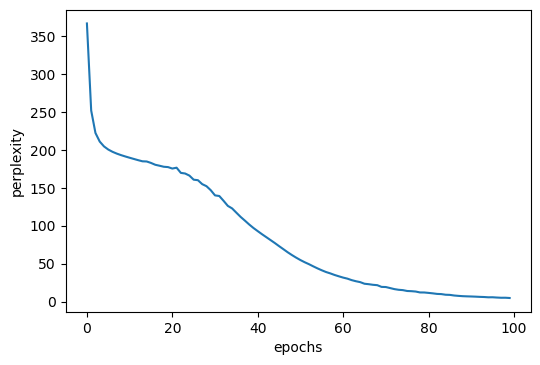

In [73]:
# 绘制图形
plt.figure(dpi=100)
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

由图可知，随着学习的进行，困惑度稳步下降。

一开始超过 300的困惑度到最后接近 1（最小值）了。

不过这里使用的是很小的语料库，在实际情况下，当语料库增大时，现在的模型根本无法招架。

下一章我们将指出当前 RNNLM 存在的问题，并进行改进。

### RNNLM的Trainer类

本书提供了用于学习 RNNLM 的 RnnlmTrainer 类，其内部封装了刚才
的 RNNLM 的学习。将刚才的学习代码重构为 RnnlmTrainer 类，结果如下。
这里只摘录源代码的一部分（全部代码在 ch05/train.py 中）。

In [74]:
# common
class RnnlmTrainer:
    def __init__(self, model, optimizer):
        self.model = model
        self.optimizer = optimizer
        self.time_idx = None
        self.ppl_list = None
        self.eval_interval = None
        self.current_epoch = 0

    def get_batch(self, x, t, batch_size, time_size):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')

        data_size = len(x)
        jump = data_size // batch_size
        offsets = [i * jump for i in range(batch_size)]  # mini-batch的各笔样本数据的开始位置

        for time in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, time] = x[(offset + self.time_idx) % data_size]
                batch_t[i, time] = t[(offset + self.time_idx) % data_size]
            self.time_idx += 1
        return batch_x, batch_t

    def fit(self, xs, ts, max_epoch=10, batch_size=20, time_size=35, max_grad=None, eval_interval=20):
        data_size = len(xs)
        max_iters = data_size // (batch_size * time_size)
        self.time_idx = 0
        self.ppl_list = []
        self.eval_interval = eval_interval
        model, optimizer = self.model, self.optimizer
        total_loss = 0
        loss_count = 0

        start_time = time.time()
        for epoch in range(max_epoch):
            for iters in range(max_iters):
                batch_x, batch_t = self.get_batch(xs, ts, batch_size, time_size)

                # 计算梯度，更新参数
                loss = model.forward(batch_x, batch_t)
                model.backward()
                params, grads = remove_duplicate(model.params, model.grads)  # 将共享的权重整合为1个
                if max_grad is not None:
                    clip_grads(grads, max_grad)
                optimizer.update(params, grads)
                total_loss += loss
                loss_count += 1

                # 评价困惑度
                if (eval_interval is not None) and (iters % eval_interval) == 0:
                    ppl = np.exp(total_loss / loss_count)
                    elapsed_time = time.time() - start_time
                    print('| epoch %d |  iter %d / %d | time %d[s] | perplexity %.2f'
                          % (self.current_epoch + 1, iters + 1, max_iters, elapsed_time, ppl))
                    self.ppl_list.append(float(ppl))
                    total_loss, loss_count = 0, 0

            self.current_epoch += 1

    def plot(self, ylim=None):
        x = numpy.arange(len(self.ppl_list))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.plot(x, self.ppl_list, label='train')
        plt.xlabel('iterations (x' + str(self.eval_interval) + ')')
        plt.ylabel('perplexity')
        plt.show()


| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 419.09
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 384.72
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 264.30
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 222.36
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 210.01
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 207.50
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 201.37
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.55
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.54
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 189.79
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 191.18
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 187.78
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 191.73
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 186.42
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 185.22
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 188.57
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 188.78
| epoch 18 |  iter 1 / 

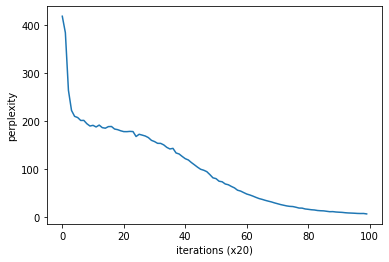

In [75]:
# ch05/train.py

# coding: utf-8
# import sys
# sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
# from dataset import ptb
# from simple_rnnlm import SimpleRnnlm


# 设定超参数
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN的隐藏状态向量的元素个数
time_size = 5  # RNN的展开大小
lr = 0.1
max_epoch = 100

# 读入训练数据
corpus, word_to_id, id_to_word = load_data('train')
corpus_size = 1000  # 缩小测试用的数据集
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 输入
ts = corpus[1:]  # 输出（监督标签）

# 生成模型
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()


如上所示，首先使用 model 和 optimizer 初始化 RnnlmTrainer 类，然后调用 fit()，完成学习。

此时，RnnlmTrainer 类的内部将执行上一节进行的一系列操作，具体如下所示。

•　按顺序生成 mini-batch

•　调用模型的正向传播和反向传播

•　使用优化器更新权重

•　评价困惑度

RnnlmTrainer类 与 1.4.4 节中介绍的 Trainer类有相同的 API

神经网络的常规学习使用 Trainer 类，而 RNNLM 的学习则使用RnnlmTrainer类

使用 RnnlmTrainer 类，可以避免每次写重复的代码。本书的剩余部分都
将使用 RnnlmTrainer 类学习 RNNLM。

## 小结

![](./img/bq13.png)

记得三连，最好打钱

爱你呦~~

让我我康康是谁只收藏不点赞的